In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Package imports
import datetime as dt
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from swarmpal.io import PalDataItem, PalProcess, create_paldata

Using MMA_2E code attached as git submodule

- See <https://github.com/natgomezperez/MMA-2E>
- Changes made locally:
  - Change `np.NaN` to `np.nan` (Numpy 2.0 change)

In [3]:
from upstream_MMA_2E.MMA_2E.utils import configuration as MMA_2E_config
from upstream_MMA_2E.MMA_2E.qmatrix import estimate_SH_coefficients_1D
from upstream_MMA_2E.MMA_2E.utils.Coord_Trans import get_MagLat

In [4]:
# Local imports
# mjd2000 copied from chaosmagpy because of not working in Python 3.12+ https://github.com/ancklo/ChaosMagPy/issues/9
from mjd2000 import mjd2000

## Set configurations

In [5]:
# Global parameters (should always remain the same)
MODEL = "'Model' = 'CHAOS-Core' + 'CHAOS-Static'"
MODEL_WITH_IONO = "'Model' = 'CHAOS-Core' + 'CHAOS-Static' + 'MIO_SHA_2C'"
VIRES_AUXILIARIES = ["MLT", "QDLat", "Dst", "QDBasis", "DipoleAxisVector"]
AVAILABLE_DATASETS = {"Swarm-A": "SW_OPER_MAGA_LR_1B", "Swarm-B": "SW_OPER_MAGB_LR_1B"}
SAMPLING_STEP = "PT25S"

# Tunable parameters
PARAMS = {"LT_limit": 6, "min_gm_lat": 0, "max_gm_lat": 65}
# TODO: See what should be included here from MMA_2E/utils/Config.py

# Local settings (changes with each run) - these determine what external data is used
START_TIME = dt.datetime(2024, 10, 1)
END_TIME = dt.datetime(2024, 11, 1)
# START_TIME = dt.datetime(2024, 10, 1)
# END_TIME = dt.datetime(2024, 10, 2)
SPACECRAFTS_TO_USE = ["Swarm-A", "Swarm-B"]  # corresponds to AVAILABLE_DATASETS

## Fetch data using SwarmPAL

Replicates what is done in `MMA_2E/utils/GetResiduals.py`

In [6]:
def get_paldatatime_vires_config(
    collection=None, start_time=None, end_time=None, model=None
):
    """Set of options which are passed through to viresclient
    For options, see https://swarmpal.readthedocs.io/en/latest/api/io.html#swarmpal.io.PalDataItem.from_vires
    """
    return dict(
        collection=collection,
        measurements=["B_NEC"],
        models=[model],
        auxiliaries=VIRES_AUXILIARIES,
        sampling_step=SAMPLING_STEP,
        start_time=start_time,
        end_time=end_time,
        server_url="https://vires.services/ows",
        options=dict(asynchronous=True, show_progress=True),
    )


start_time = START_TIME
end_time = END_TIME
model = MODEL
data_config = {
    spacecraft: get_paldatatime_vires_config(
        collection=AVAILABLE_DATASETS.get(spacecraft),
        start_time=start_time,
        end_time=end_time,
        model=model,
    )
    for spacecraft in SPACECRAFTS_TO_USE
}
data_config

{'Swarm-A': {'collection': 'SW_OPER_MAGA_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 10, 1, 0, 0),
  'end_time': datetime.datetime(2024, 11, 1, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}},
 'Swarm-B': {'collection': 'SW_OPER_MAGB_LR_1B',
  'measurements': ['B_NEC'],
  'models': ["'Model' = 'CHAOS-Core' + 'CHAOS-Static'"],
  'auxiliaries': ['MLT', 'QDLat', 'Dst', 'QDBasis', 'DipoleAxisVector'],
  'sampling_step': 'PT25S',
  'start_time': datetime.datetime(2024, 10, 1, 0, 0),
  'end_time': datetime.datetime(2024, 11, 1, 0, 0),
  'server_url': 'https://vires.services/ows',
  'options': {'asynchronous': True, 'show_progress': True}}}

In [7]:
data = create_paldata(
    **{
        label: PalDataItem.from_vires(**data_params)
        for label, data_params in data_config.items()
    }
)
print(data)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (17.275MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (17.275MB)

<xarray.DataTree 'paldata'>
Group: /
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 107136, NEC: 3, QDBasis_dim1: 2,
│                              QDBasis_dim2: 2, DipoleAxisVector_dim1: 3)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 857kB 2024-10-01 ... 2024-10...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: QDBasis_dim1, QDBasis_dim2,
│                                       DipoleAxisVector_dim1
│       Data variables:
│           Spacecraft        (Timestamp) object 857kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           B_NEC             (Timestamp, NEC) float64 3MB 1.436e+04 491.0 ... 1.264e+04
│           QDBasis           (Timestamp, QDBasis_dim1, QDBasis_dim2) float64 3MB 1.0...
│           QDLat             (Timestamp) float64 857kB 48.93 47.29 ... 13.24 14.85
│           Latitude          (Timestamp) float64 857kB 52.65 51.06 ... 8.612 10.21
│           MLT               (Timestamp)

## Data preprocessing

See `MMA_2E/utils/GetResiduals.py`. Gets data into the form expected by `MMA_2E/qmatrix.py`

In [8]:
def extract_simplified_dataframe(ds):
    B_res_NEC = ds.swarmpal.magnetic_residual()
    return pd.DataFrame(
        {
            "t": mjd2000(ds["Timestamp"]),
            "r": ds["Radius"] / 1000,  # Rad in km
            "phi": ds["Longitude"],
            "theta": 90 - ds["Latitude"],  # Colatitude in degrees
            "B_rtp_1": -B_res_NEC.data[:, 2],  # Rad is -Center
            "B_rtp_2": -B_res_NEC.data[:, 0],  # Theta is -North
            "B_rtp_3": B_res_NEC.data[:, 1],
            "sat": ds["Spacecraft"],
            # 'MLT'    : ds["MLT"],
            "time": ds["Timestamp"],
        }
    )

In [9]:
# Extract one dataset
extract_simplified_dataframe(data["Swarm-A"])

,t,r,phi,theta,B_rtp_1,B_rtp_2,B_rtp_3,sat,time
0,9040.000000,6832.27259,91.220385,37.345231,-24.357096,20.676559,3.892633,A,2024-10-01 00:00:00
1,9040.000289,6832.53044,91.311377,38.942106,-24.024498,21.545206,1.774594,A,2024-10-01 00:00:25
2,9040.000579,6832.79556,91.389319,40.539225,-23.632605,22.279618,0.950466,A,2024-10-01 00:00:50
3,9040.000868,6833.06756,91.455731,42.136549,-22.921310,22.379470,0.385752,A,2024-10-01 00:01:15
4,9040.001157,6833.34601,91.511911,43.734045,-22.614010,23.475953,0.704319,A,2024-10-01 00:01:40
...,...,...,...,...,...,...,...,...,...
107131,9070.998553,6838.22143,-126.367814,86.182531,11.090262,75.009162,-2.495784,A,2024-10-31 23:57:55
107132,9070.998843,6837.93275,-126.397430,84.584493,8.135665,74.078900,-4.971477,A,2024-10-31 23:58:20
107133,9070.999132,6837.64004,-126.426644,82.986342,7.488050,72.467833,-5.440080,A,2024-10-31 23:58:45
107134,9070.999421,6837.34356,-126.455332,81.388081,7.166452,70.586702,-3.804216,A,2024-10-31 23:59:10


In [10]:
# Extract all datasets
pd.concat(
    [extract_simplified_dataframe(data[label]) for label in SPACECRAFTS_TO_USE],
    ignore_index=True,
)

,t,r,phi,theta,B_rtp_1,B_rtp_2,B_rtp_3,sat,time
0,9040.000000,6832.27259,91.220385,37.345231,-24.357096,20.676559,3.892633,A,2024-10-01 00:00:00
1,9040.000289,6832.53044,91.311377,38.942106,-24.024498,21.545206,1.774594,A,2024-10-01 00:00:25
2,9040.000579,6832.79556,91.389319,40.539225,-23.632605,22.279618,0.950466,A,2024-10-01 00:00:50
3,9040.000868,6833.06756,91.455731,42.136549,-22.921310,22.379470,0.385752,A,2024-10-01 00:01:15
4,9040.001157,6833.34601,91.511911,43.734045,-22.614010,23.475953,0.704319,A,2024-10-01 00:01:40
...,...,...,...,...,...,...,...,...,...
214267,9070.998553,6876.30881,122.263355,68.854363,-2.976681,43.974178,-5.866035,B,2024-10-31 23:57:55
214268,9070.998843,6876.00377,122.231207,67.269237,-4.626963,43.677433,-5.359857,B,2024-10-31 23:58:20
214269,9070.999132,6875.69797,122.200761,65.684047,-6.233249,43.079235,-7.109513,B,2024-10-31 23:58:45
214270,9070.999421,6875.39180,122.172198,64.098800,-6.476209,40.971611,-5.110570,B,2024-10-31 23:59:10


In [11]:
def convert_longitude_to_local_time(longitude_deg, t):
    longitude_deg = (longitude_deg / 360) + (t % 1)
    return (longitude_deg % 1) * 24


def merge_and_select_data(
    data,
    lt_limit=PARAMS["LT_limit"],
    min_gm_lat=PARAMS["min_gm_lat"],
    max_gm_lat=PARAMS["max_gm_lat"],
):
    df = pd.concat(
        [extract_simplified_dataframe(data[label]) for label in SPACECRAFTS_TO_USE],
        ignore_index=True,
    )
    # Local time and magnetic latitude masks
    local_time = convert_longitude_to_local_time(df["phi"], df["t"])
    mask_lt = np.logical_or(local_time < lt_limit, local_time > (24 - lt_limit))
    lat_mag = get_MagLat(90 - df.theta, df.phi, df.time)
    mask_maglat = np.logical_and(
        np.abs(lat_mag) >= min_gm_lat, np.abs(lat_mag) <= max_gm_lat
    )
    return df[np.logical_and(mask_lt, mask_maglat)]

In [12]:
merge_and_select_data(data)

,t,r,phi,theta,B_rtp_1,B_rtp_2,B_rtp_3,sat,time
112,9040.032407,6848.49363,-100.651824,143.898791,21.553407,16.799994,-3.588403,A,2024-10-01 00:46:40
113,9040.032697,6848.41133,-100.550339,142.309699,19.928852,17.146682,-3.247624,A,2024-10-01 00:47:05
114,9040.032986,6848.32405,-100.463128,140.720173,18.805694,18.359579,-3.135084,A,2024-10-01 00:47:30
115,9040.033275,6848.23165,-100.388491,139.130250,17.331097,19.023883,-2.902404,A,2024-10-01 00:47:55
116,9040.033565,6848.13400,-100.324983,137.539961,16.153757,19.995017,-2.579378,A,2024-10-01 00:48:20
...,...,...,...,...,...,...,...,...,...
214165,9070.969039,6884.62099,-46.071359,129.756229,23.256624,61.792641,-11.724087,B,2024-10-31 23:15:25
214166,9070.969329,6884.73327,-46.068358,131.336110,24.486136,60.455871,-11.557285,B,2024-10-31 23:15:50
214167,9070.969618,6884.84031,-46.060017,132.915774,25.486009,58.917100,-12.841083,B,2024-10-31 23:16:15
214168,9070.969907,6884.94222,-46.045744,134.495214,26.617159,57.233688,-14.246240,B,2024-10-31 23:16:40


In [13]:
def clean_data(df):
    threshold = 15
    outliers = pd.Series(data=False, index=df.index)
    for vi in range(1, 4):
        vec_c = "B_rtp_" + str(vi)
        z = np.abs(stats.zscore(df[vec_c]))
        outliers = (z > threshold) | outliers
    return df[~outliers]

In [14]:
df = clean_data(merge_and_select_data(data))
df

,t,r,phi,theta,B_rtp_1,B_rtp_2,B_rtp_3,sat,time
112,9040.032407,6848.49363,-100.651824,143.898791,21.553407,16.799994,-3.588403,A,2024-10-01 00:46:40
113,9040.032697,6848.41133,-100.550339,142.309699,19.928852,17.146682,-3.247624,A,2024-10-01 00:47:05
114,9040.032986,6848.32405,-100.463128,140.720173,18.805694,18.359579,-3.135084,A,2024-10-01 00:47:30
115,9040.033275,6848.23165,-100.388491,139.130250,17.331097,19.023883,-2.902404,A,2024-10-01 00:47:55
116,9040.033565,6848.13400,-100.324983,137.539961,16.153757,19.995017,-2.579378,A,2024-10-01 00:48:20
...,...,...,...,...,...,...,...,...,...
214165,9070.969039,6884.62099,-46.071359,129.756229,23.256624,61.792641,-11.724087,B,2024-10-31 23:15:25
214166,9070.969329,6884.73327,-46.068358,131.336110,24.486136,60.455871,-11.557285,B,2024-10-31 23:15:50
214167,9070.969618,6884.84031,-46.060017,132.915774,25.486009,58.917100,-12.841083,B,2024-10-31 23:16:15
214168,9070.969907,6884.94222,-46.045744,134.495214,26.617159,57.233688,-14.246240,B,2024-10-31 23:16:40


## Apply the "qmatrix.estimate_SH_coefficients" code

- Uses the `params` defined using the config tooling in `MMA_2E/utils.configuration.py`
- See `MMA_2E/utils/qmatrix.py`

In [15]:
def apply_mma_2e_code(df: pd.DataFrame) -> xr.Dataset:
    params = MMA_2E_config.BasicConfig()
    params.fullreset()
    ds = estimate_SH_coefficients_1D(df, params)
    return ds


ds = apply_mma_2e_code(df)

Data range and integration time 9070.973958333334 9040.0 0.3333333333333333
Done 0 out of 93



In [16]:
print(ds)

<xarray.Dataset> Size: 28kB
Dimensions:       (93: 93, 15: 15, R2_e: 93, R2_i: 93, data_per_bin: 93,
                   Cm_cond_e: 93, Cm_cond_i: 93, MSER_i: 93, MSER_e: 93,
                   time: 93)
Coordinates:
  * R2_e          (R2_e) float64 744B 0.9567 0.9698 0.951 ... 0.9818 0.8906
  * R2_i          (R2_i) float64 744B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * data_per_bin  (data_per_bin) float64 744B 1.348e+03 1.352e+03 ... 1.32e+03
  * Cm_cond_e     (Cm_cond_e) float64 744B 17.48 17.78 31.88 ... 6.049 6.055
  * Cm_cond_i     (Cm_cond_i) float64 744B 16.17 28.0 30.98 ... 7.945 8.189
  * MSER_i        (MSER_i) float64 744B 9.184 3.655 5.251 ... 2.691 3.047 7.41
  * MSER_e        (MSER_e) float64 744B 25.19 11.07 13.14 ... 4.197 7.023 57.71
  * time          (time) float64 744B 9.04e+03 9.04e+03 ... 9.07e+03 9.071e+03
Dimensions without coordinates: 93, 15
Data variables:
    qs            (93, 15) float64 11kB 30.9 2.736 -0.8906 ... 0.5359 0.6398
    gh            (93, 15) f

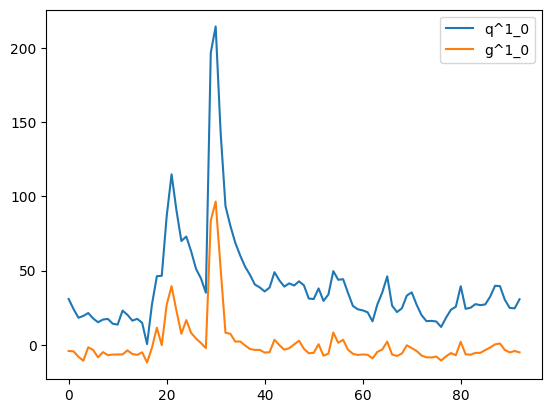

In [17]:
plt.plot(ds["qs"][:, 0], label="q^1_0")
plt.plot(ds["gh"][:, 0], label="g^1_0")
plt.legend()

## Expressing the above as a SwarmPAL Process

In [18]:
class MMA_SHA_2E_PAL(PalProcess):
    @property
    def process_name(self):
        return "MMA_SHA_2E"

    def set_config(self, **PARAMS):
        self.config = dict(**PARAMS)

    def _call(self, datatree):
        # Preprocess data
        df = clean_data(merge_and_select_data(datatree))
        # Perform analysis
        params = MMA_2E_config.BasicConfig()
        params.fullreset()
        ds = estimate_SH_coefficients_1D(df, params)
        datatree["MMA_SHA_2E"] = xr.DataTree(ds)
        return datatree

In [19]:
process = MMA_SHA_2E_PAL()
process.set_config(**PARAMS)

In [20]:
data = process(data)
print(data)

Data range and integration time 9070.973958333334 9040.0 0.3333333333333333
Done 0 out of 93

<xarray.DataTree 'paldata'>
Group: /
│   Attributes:
│       PAL_meta:  {"MMA_SHA_2E": {"LT_limit": 6, "min_gm_lat": 0, "max_gm_lat": ...
├── Group: /Swarm-A
│       Dimensions:           (Timestamp: 107136, NEC: 3, QDBasis_dim1: 2,
│                              QDBasis_dim2: 2, DipoleAxisVector_dim1: 3)
│       Coordinates:
│         * Timestamp         (Timestamp) datetime64[ns] 857kB 2024-10-01 ... 2024-10...
│         * NEC               (NEC) <U1 12B 'N' 'E' 'C'
│       Dimensions without coordinates: QDBasis_dim1, QDBasis_dim2,
│                                       DipoleAxisVector_dim1
│       Data variables:
│           Spacecraft        (Timestamp) object 857kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
│           B_NEC             (Timestamp, NEC) float64 3MB 1.436e+04 491.0 ... 1.264e+04
│           QDBasis           (Timestamp, QDBasis_dim1, QDBasis_dim2) float64 3MB 1.0...
│           QD

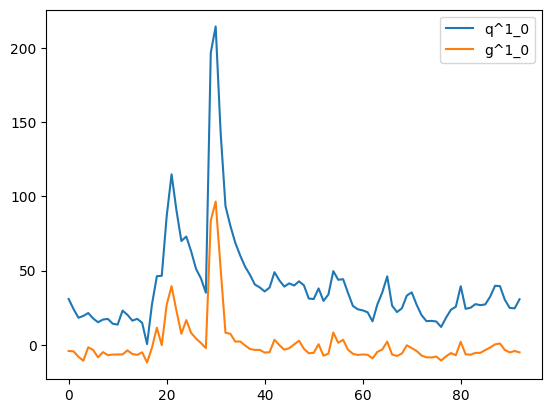

In [21]:
def quicklook(data):
    qs10 = data["MMA_SHA_2E"]["qs"][:, 0]
    gh10 = data["MMA_SHA_2E"]["gh"][:, 0]
    plt.plot(ds["qs"][:, 0], label="q^1_0")
    plt.plot(ds["gh"][:, 0], label="g^1_0")
    plt.legend()


quicklook(data)